# Лабораторная работа №3. Бинарная сегментация избражений

In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(0)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
path = 'W:\\datasets\\segmentation\\person_segmentation\\train\\'
os.listdir(path)

['images', 'masks']

In [5]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'images':
        img_pathes = pathes
    elif folder == 'masks':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

In [6]:
lbl_pathes[:5]

['W:\\datasets\\segmentation\\person_segmentation\\train\\masks\\1.png',
 'W:\\datasets\\segmentation\\person_segmentation\\train\\masks\\10.png',
 'W:\\datasets\\segmentation\\person_segmentation\\train\\masks\\100.png',
 'W:\\datasets\\segmentation\\person_segmentation\\train\\masks\\1000.png',
 'W:\\datasets\\segmentation\\person_segmentation\\train\\masks\\1001.png']

In [7]:
import torch
from torch.utils import data

T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    def __init__(self, path, subset = 'train', transform = None):

        for folder in os.listdir(path):
            pathes = []
            for pth, dirs, files in os.walk(os.path.join(path, folder)):
                for file in files:
                    pathes.append(os.path.join(pth, file))
            if folder == 'images':
                img_pathes = pathes
            elif folder == 'masks':
                lbl_pathes = pathes
   
        img_pathes.sort()
        lbl_pathes.sort()
        
        items = list(zip(img_pathes, lbl_pathes))
        
        if subset == 'train':
            self.items = items[: int(.7 * len(items))]
        elif subset == 'valid':
            self.items = items[int(.7 * len(items)): int(.9 * len(items))]
        elif subset == 'test':
            self.items = items[int(.9 * len(items)):]
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name = self.items[index]

        image = Image.open(img_name)
        mask = Image.open(msk_name).convert('L')

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [8]:
data = Dataset(path, subset='train', transform=None)

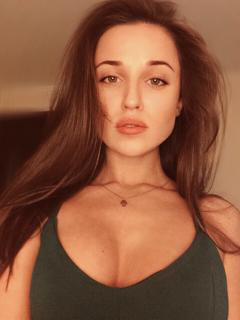

In [9]:
img, msk = data[14]
img

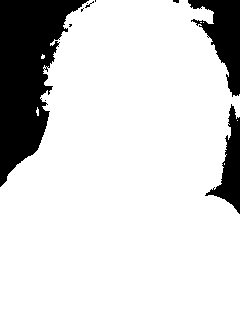

In [10]:
msk

In [11]:
train_data = Dataset(path, subset='train', transform=T)
valid_data = Dataset(path, subset='valid', transform=T)
test_data = Dataset(path, subset='test', transform=T)

In [12]:
train_data.__len__(), valid_data.__len__(), test_data.__len__()

(1043, 298, 150)

In [13]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=32, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=32, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False)

In [14]:
import segmentation_models_pytorch as smp

model = smp.Unet('resnet34').to(device)

In [15]:
#model

In [16]:
from torch import nn 

loss = nn.BCEWithLogitsLoss()
#loss = smp.utils.losses.BCEDiceLoss(eps=1.)
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-4},  
])

In [17]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)


In [18]:
%%time
max_score = 0
train_logs_list = []
valid_logs_list = []
for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou']:
#         max_score = valid_logs['iou']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')
        

    #if i == 5:
     #   optimizer.param_groups[1]['lr'] = 1e-5
      #  print('Decrease decoder learning rate to 1e-5!')



Epoch: 0
valid: 100%|████████████████████████| 10/10 [00:02<00:00,  4.83it/s, bce_loss - 0.1334, iou - 0.9308, f-score - 0.9641]

Epoch: 1
valid: 100%|█████████████████████████| 10/10 [00:02<00:00,  4.97it/s, bce_loss - 0.1113, iou - 0.9475, f-score - 0.973]

Epoch: 2
valid: 100%|████████████████████████| 10/10 [00:02<00:00,  4.98it/s, bce_loss - 0.09965, iou - 0.952, f-score - 0.9754]

Epoch: 3
valid: 100%|███████████████████████| 10/10 [00:02<00:00,  4.86it/s, bce_loss - 0.09121, iou - 0.9538, f-score - 0.9764]

Epoch: 4
valid: 100%|████████████████████████| 10/10 [00:02<00:00,  4.91it/s, bce_loss - 0.0882, iou - 0.9528, f-score - 0.9758]

Epoch: 5
valid: 100%|█████████████████████████| 10/10 [00:02<00:00,  4.97it/s, bce_loss - 0.0832, iou - 0.956, f-score - 0.9775]

Epoch: 6
valid: 100%|███████████████████████| 10/10 [00:02<00:00,  4.96it/s, bce_loss - 0.07665, iou - 0.9582, f-score - 0.9787]

Epoch: 7
valid: 100%|███████████████████████| 10/10 [00:02<00:00,  4.86it/s, bce_loss - 0

In [19]:
test_logs = valid_epoch.run(test_loader)
test_logs

valid: 100%|█████████████████████| 150/150 [00:04<00:00, 34.07it/s, bce_loss - 0.07993, iou - 0.9602, f-score - 0.9794]


{'bce_loss': 0.07993124481290577,
 'iou': 0.9602167320251466,
 'f-score': 0.9793563421567283}

In [20]:
train_bce_loss, valid_bce_loss = [], []
train_iou, valid_iou = [], []
train_f_score, valid_f_score = [], []
for i in range(len(train_logs_list)): #epochs
    train_bce_loss.append(train_logs_list[i]['bce_loss'])
    valid_bce_loss.append(valid_logs_list[i]['bce_loss'])
    train_iou.append(train_logs_list[i]['iou'])
    valid_iou.append(valid_logs_list[i]['iou'])
    train_f_score.append(train_logs_list[i]['f-score'])
    valid_f_score.append(valid_logs_list[i]['f-score'])
    test_bce_loss = test_logs['bce_loss']
    test_iou = test_logs['iou']
    test_f_score = test_logs['f-score']

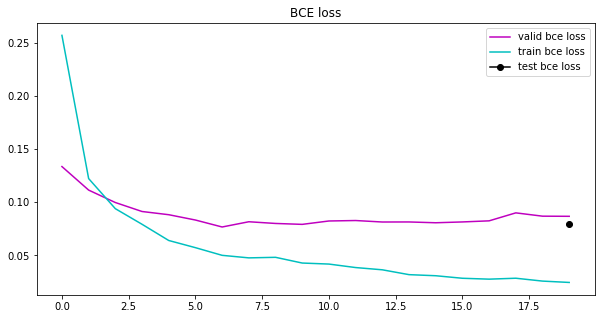

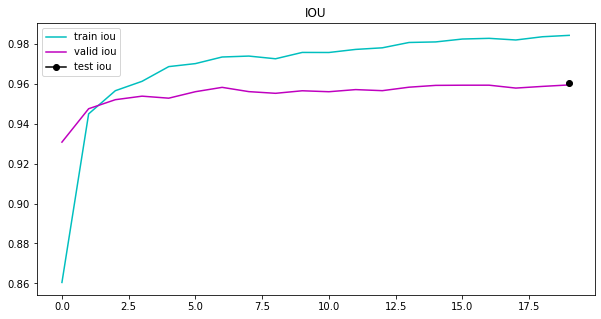

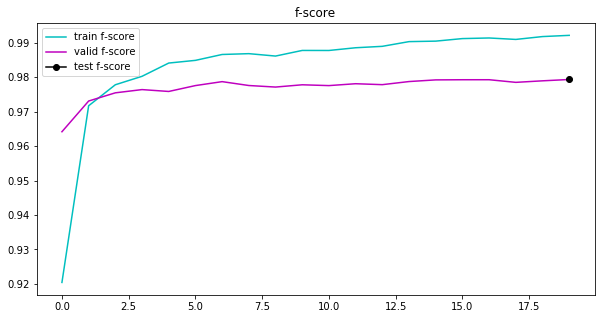

In [21]:
plt.figure(figsize=(10, 5))
plt.title("BCE loss")
plt.plot(valid_bce_loss, 'm', label='valid bce loss')
plt.plot(train_bce_loss, 'c', label='train bce loss')
plt.plot(19, test_bce_loss, 'k', label='test bce loss', marker='o')
plt.legend();

plt.figure(figsize=(10, 5))
plt.title("IOU")
plt.plot(train_iou, 'c', label='train iou')
plt.plot(valid_iou, 'm', label='valid iou')
plt.plot(19, test_iou, 'k', label='test iou', marker='o')
plt.legend();

plt.figure(figsize=(10, 5))
plt.title("f-score")
plt.plot(train_f_score, 'c', label='train f-score')
plt.plot(valid_f_score, 'm', label='valid f-score')
plt.plot(19, test_f_score, 'k', label='test f-score', marker='o')
plt.legend();

In [130]:
import pandas as pd 

## Encoders + Loss
- epochs 20
- optimizer Adam
- decoder lr 1e-3 [0-4] epoch 1e-5 [5-19] epoch    
- encoder lr 1e-5 

|file #.csv|encoder|Model size (Mb)|batch size|loss|**loss** train|valid|test|**iou** train|valid|test|**f-score** train|valid|test|time  
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---
|1|resnet34|84|16|BCEWithLogitsLoss|0.039911|0.081160|0.071621|0.977272|0.954577|0.955233|0.988502|0.976744|0.976704|6 m 9 s   
|2|resnet34|84|16|BCEDiceLoss|<span style="color:red">0.062243</span>|0.118301|0.120104|0.976545|0.953665|0.951078|0.988128|0.976266|0.974426|6 m 8 s  
|3|resnet18|45|16|BCEWithLogitsLoss|0.043622|0.090886|0.089423|0.975920|0.950053|0.946369|0.987810|0.974360|0.971832|<span style="color:green">5min 8s</span>
|4|resnet152|231|8|BCEWithLogitsLoss|0.029831|0.070434|0.062796|0.981771|0.960970|0.962297|0.990798|0.980046|0.980502|19min 40s 
|5|VGG11|507|16|BCEWithLogitsLoss|0.038022|0.116237|0.119826|0.979096|0.939383|0.932264|0.989434|0.968722|0.962595|6min 28s
|6|VGG19|<span style="color:red">548</span>|16|BCEWithLogitsLoss|0.036545|0.087776|0.083814|0.979461|0.953527|0.952378|0.989621|0.976181|0.975035|9min 42s
|7|<span style="color:green">senet154</span>|440|4|BCEWithLogitsLoss|<span style="color:green">0.026170</span>|0.066732|0.066549|<span style="color:green">0.982882</span>|<span style="color:green">0.964917</span>|<span style="color:green">0.96346</span>|<span style="color:green">0.991359</span>|<span style="color:green">0.982085</span>|<span style="color:green">0.981079</span>|<span style="color:red">1h 14min 41s</span>
|8|<span style="color:red">inceptionresnetv2</span>|213|8|BCEWithLogitsLoss|0.040183|<span style="color:red">0.165186</span>|<span style="color:red">0.156692</span>|0.976034|<span style="color:red">0.926532</span>|<span style="color:red">0.928107</span>|0.987860|<span style="color:red">0.961247</span>|<span style="color:red">0.958759</span>| 26min 40s
|9|densenet121|<span style="color:green">30.9</span>|16|BCEWithLogitsLoss|0.040188|0.081998|0.078816|0.976974|0.954427|0.954993|0.988348|0.976669|0.976412|10min 31s 
|10|densenet161|110|8|BCEWithLogitsLoss|0.029052|0.070750|0.072356|0.981643|0.961918|0.958593|0.990734|0.980547|0.978403|23min 45s 
|11|dpn68|48.4|16|BCEWithLogitsLoss|0.045732|0.088068|0.073468|<span style="color:red">0.974763</span>|0.950687|0.953653|<span style="color:red">0.987216</span>|0.974696|0.975877|10min 35s
|12|<span style="color:green">dpn131</span>|303|4|BCEWithLogitsLoss|0.026775|<span style="color:green">0.063710</span>|<span style="color:green">0.061465</span>|0.982375|0.964326|0.963359|0.991104|0.981774|<span style="color:green">0.981099</span>|52min 20s





## ResNet 18 batch size
- epochs 20
- optimizer Adam
- decoder lr 1e-3 [0-4] epoch 1e-5 [5-19] epoch
- encoder lr 1e-5
- BCEWithLogitsLoss

|file #.csv|batch size|**loss** train|valid|test|**iou** train|valid|test|**f-score** train|valid|test|time  
|---|---|---|---|---|---|---|---|---|---|---|---
|13|<span style="color:red">**32**</span>|0.060590|0.107330|0.106449|0.975262|0.945053|0.941578|0.987473|0.971742|0.968947|<span style="color:green">4min 57s</span>
|14|16|0.044653|0.093527|0.095478|0.975515|0.947522|0.941696|0.987601|0.973032|0.968894|5min 23s
|15|8|0.039143|0.089366|0.089342|0.975662|0.950379|0.946188|0.987675|0.974492|0.971556|6min 31s
|16|<span style="color:green">**4**</span>|0.037148|0.084860|0.080322|0.975735|0.951695|0.950756|0.987620|0.975118|0.974223|<span style="color:red">9min 5s</span>

## ResNet 18 encoder decoder lr
- epochs 20
- optimizer Adam
- BCEWithLogitsLoss
- batch size 32

|file #.csv|decoder lr|decay|encoder lr|decay|**loss** train|valid|test|**iou** train|valid|test|**f-score** train|valid|test|time  
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---
|<span style="color:green">**17**</span>|1e-3|nope|1e-3|nope|0.031171|0.101222|<span style="color:green">0.079372</span>|0.981081|0.950460|<span style="color:green">0.95401</span>|0.990449|0.974578|<span style="color:green">0.975883</span>|4min 49s
|<span style="color:green">**19**</span>|1e-3|nope|1e-4|nope|0.025973|<span style="color:green">0.090684</span>|0.090963|0.983672|<span style="color:green">0.955536</span>|0.952042|0.991768|<span style="color:green">0.977254</span>|0.974863|4min 46s
|18|1e-3|nope|1e-5|nope|0.029396|0.101788|0.101804|0.981359|0.949327|0.947189|0.990592|0.973996|0.971946|4min 46s
|20|1e-3|nope|1e-3|5/1e-5|0.035915|0.113808|0.09794|0.977349|0.947736|0.948185|0.988543|0.973139|0.9726|4min 48s
|21|1e-3|nope|1e-3|5/1e-4 10/1e-5|0.042381|0.106151|0.085394|0.978221|0.946953|0.951446|0.988989|0.972742|0.974638|4min 51s
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---
|<span style="color:green">**17**</span>|1e-3|nope|1e-3|nope|0.031171|0.101222|<span style="color:green">0.079372</span>|0.981081|0.950460|<span style="color:green">0.95401</span>|0.990449|0.974578|<span style="color:green">0.975883</span>|4min 49s
|<span style="color:green">**22**</span>|1e-4|nope|1e-3|nope|<span style="color:green">0.028095</span>|<span style="color:green">0.091571</span>|0.093384|<span style="color:green">0.983204</span>|<span style="color:green">0.954475</span>|0.95016|<span style="color:green">0.991530</span>|<span style="color:green">0.976698</span>|0.973913|4min 45s
|23|1e-5|nope|1e-3|nope|0.032631|0.098575|0.110581|0.979602|0.950252|0.942346|0.989694|0.974480|0.96928|4min 52s
|24|1e-3|5/1e-5|1e-3|nope|0.066539|0.113934|0.106575|0.980132|0.949438|0.947937|0.989965|0.974043|0.972327|4min 56s
|25|1e-3|5/1e-4 10/1e-5|1e-3|nope|0.044056|0.104169|0.09682|0.980334|0.946827|0.943858|0.990069|0.972667|0.970232|4min 53s
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---
|26|1e-4|nope|1e-4|nope|0.065759|0.111284|0.116046|0.982941|0.950590|0.944438|0.991397|0.974663|0.970367|4min 45s
<span style="color:green"></span>

In [131]:
#df = pd.DataFrame()
#df['train_bce_loss'] = train_bce_loss
#df['valid_bce_loss'] = valid_bce_loss
#df['test_bce_loss'] = test_bce_loss
#df['train_iou'] = train_iou
#df['valid_iou'] = valid_iou
#df['test_iou'] = test_iou
#df['train_f_score'] = train_f_score
#df['valid_f_score'] = valid_f_score
#df['test_f_score'] = test_f_score

#path = 'C:\\Users\\usr\\Documents\\GitHub\\dl\\3-Person-Segmentation-UNet\\26.csv'
#df.to_csv(path, index=False)


In [132]:
#pd.read_csv('3-Person-Segmentation-UNet\\26.csv')

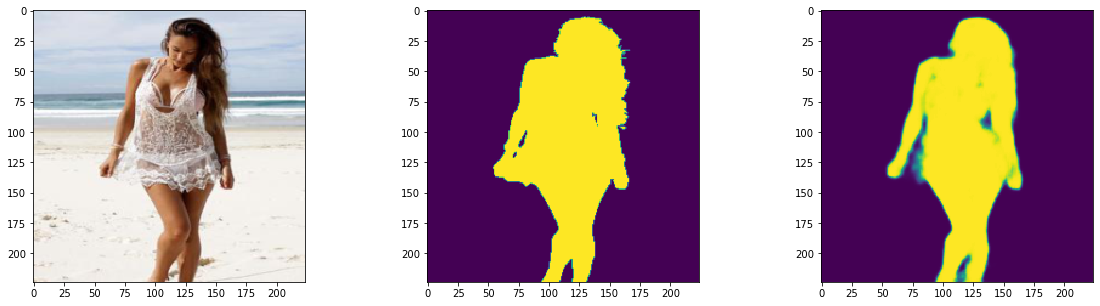

In [22]:
img, mask_true = test_data[23]
mask_pred = torch.sigmoid(model(img.unsqueeze(0).to(device)))
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(img.numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(mask_true.squeeze().numpy())
plt.subplot(133)
plt.imshow(mask_pred.squeeze().cpu().detach().numpy());
#plt.savefig('test_23_020.png')

# epochs 1-20
![alt text](20.gif)
![alt text](23.gif)
![alt text](28.gif)
![alt text](45.gif)
![alt text](63.gif)